# Model for the noise in the spectra


I had previously been estimating the noise using the blank bits of spectrum, which is ok so long as we are dominated by pattern noise or dark current, or whatever that does not depend on the signal level. 

But there also should be a photon shot noise component, which will scale with the sqrt of brightness.

So I intend to fit a linear model to the noise variance:
$$
s_\mathrm{noise}^2 = a + b I
$$
where $I$ is the counts per pixel, and $a$ and $b$ are constants for a given instrumental set up. 

For this, I will use the original files.


## Imports

In [1]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib import pyplot as plt
import seaborn as sns

## 70 micron slits

In [2]:
datadir = Path.cwd().parent / "data/originals"
_files = sorted(datadir.glob("crN1004*.fits"))
[_.stem for _ in _files]

['crN10042_b', 'crN10043_bx', 'crN10045_bx-oiii', 'crN10047o']

The middle two of these are the Ha and O III spectra that we have been using. The Ha one will be the most suitable, since it has an ISM line component, which is almost constant along the slit. So we can use the spatial variation at constant wavelength to estimate the noise as a function of brightness. 

At least for the range of brightness in the ISM line, which goes up to about 50% of the brightness of the nebula

In [3]:
hdu = fits.open(_files[1])[0]

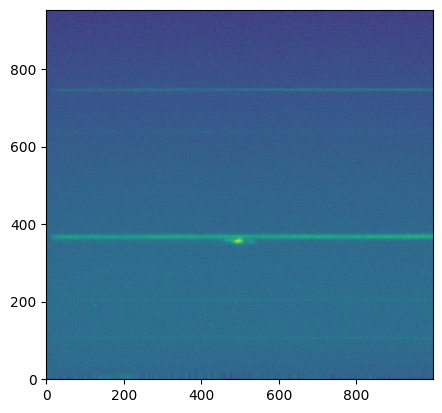

In [4]:
fig, ax = plt.subplots()
ax.imshow(hdu.data, origin="lower")

### First attempt with ISM line only

#### Mask out the nebular line with NaNs

In [5]:
im = hdu.data
im[340:370, 450:550] = np.nan

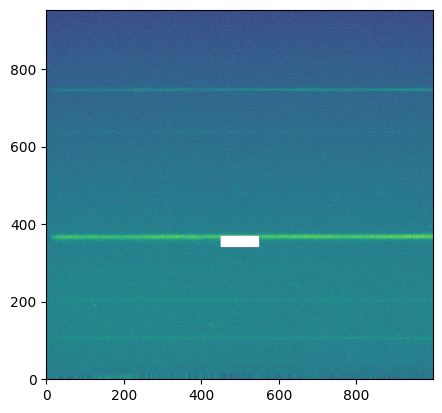

In [6]:
fig, ax = plt.subplots()
ax.imshow(im, origin="lower")

#### Calculate statistics for each wavelength row

In [7]:
row_means = np.nanmean(im, axis=1)
row_sigmas = np.nanstd(im, axis=1)

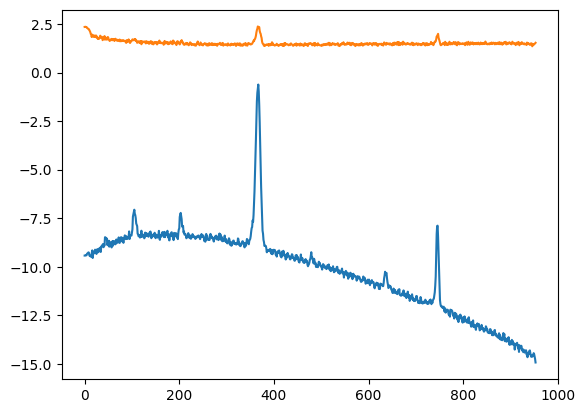

In [8]:
fig, ax = plt.subplots()
ax.plot(row_means)
ax.plot(row_sigmas)

#### Concentrate on waves near the Ha line and fit polynomial to the continuum

In [9]:
ny, nx = im.shape
pixels = np.arange(ny)

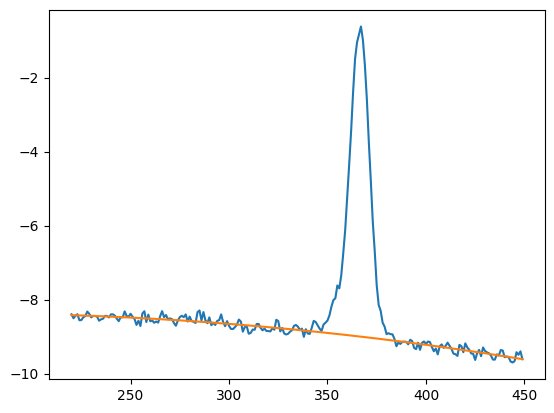

In [10]:
fig, ax = plt.subplots()
window = slice(220, 450)
x, y = pixels[window], row_means[window]
is_bg = (x < 330) | (x > 380)
p = np.polynomial.Polynomial.fit(x[is_bg], y[is_bg], deg=2)
ax.plot(x, y)
ax.plot(x, p(x))

### Fit variance versus intensity

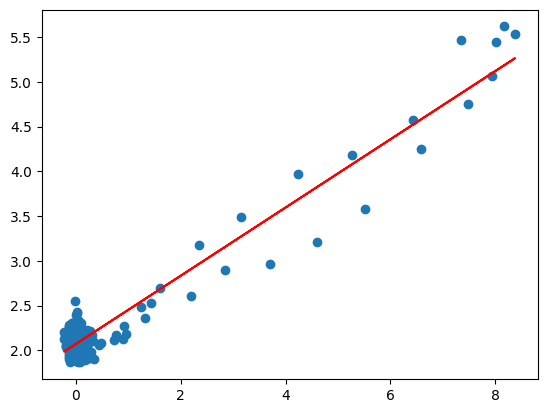

In [11]:
intensity = y - p(x)
variance = row_sigmas[window]**2
pp = np.polynomial.Polynomial.fit(intensity, variance, deg=1)
fig, ax = plt.subplots()
ax.scatter(intensity, variance)
ax.plot(intensity, pp(intensity), color="red")

In [12]:
pp.convert()

Polynomial([2.07210892, 0.38096757], domain=[-1.,  1.], window=[-1.,  1.])

So now we just need to convert this to the rebinned data scale. And also correct for the different pixel size I suppose.

## Second attempt with all pixels

Rather than calculating the total variance in each wavelength row, we could try to estimate a local variance around each pixel.  This should work well if the pixel size is small enough that the seeing and spectrograph profiles are oversampled. Since in that case, the pixel-to-pixel variations will be dominated by the noise and not by the real gradients in the spectrum.

#### Variance in 3x3 square kernel

In [127]:
def fine_variance(image):
    a = np.roll(image, (1, 0), axis=(1, 0))
    b = np.roll(image, (0, 1), axis=(1, 0))
    c = np.roll(image, (1, 1), axis=(1, 0))
    d = np.roll(image, (-1, 0), axis=(1, 0))
    e = np.roll(image, (0, -1), axis=(1, 0))
    f = np.roll(image, (-1, -1), axis=(1, 0))
    g = np.roll(image, (-1, 1), axis=(1, 0))
    h = np.roll(image, (1, -1), axis=(1, 0))
    _stack = np.stack((image, a, b, c, d, e, f, g, h))
    return (9/8) * np.nanvar(_stack, axis=0, ddof=1), np.nanmedian(_stack, axis=0)


def x_variance(image):
    a = np.roll(image, (1, 0), axis=(1, 0))
    b = np.roll(image, (-1, 0), axis=(1, 0))
    _stack = np.stack((image, a, b))
    return np.nanvar(_stack, axis=0, ddof=1), np.nanmedian(_stack, axis=0)

    

#### Zoom in on the nebula and Ha line

*Note that I have to convert the image endian format to avoid problems later. Numpy is fine with big endian data, but pandas does not like it, which cause errors with seaborn.*

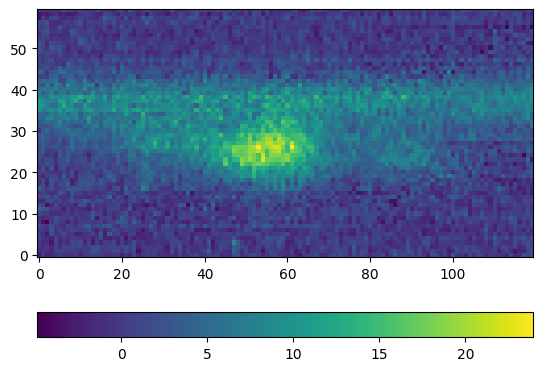

In [128]:
hdu = fits.open(_files[1])[0]
wav_window = slice(330, 390)
pos_window = slice(440, 560)
# convert to default float since fits image was big endian
im = hdu.data[wav_window, pos_window].astype("float")
bg = p(pixels)[wav_window, None]
im -= bg
fig, ax = plt.subplots()
_ = ax.imshow(im, origin="lower", interpolation="none")
fig.colorbar(_, ax=ax, orientation="horizontal")

#### Image of the variance

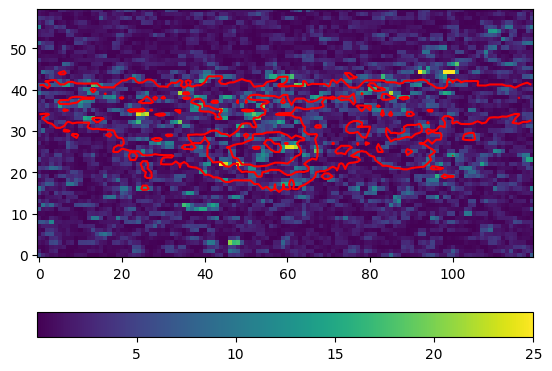

In [159]:
fig, ax = plt.subplots()
_var, _med = x_variance(im)
_ = ax.imshow(_var, origin="lower", interpolation="none", vmax=25)
fig.colorbar(_, ax=ax, orientation="horizontal")
ax.contour(_med, levels=[5, 10, 15, 20], colors="r")

#### Plot of variance versus intensity

/var/folders/0q/3pcjvc3n6sn2wk6g8ck6ry300000gn/T/ipykernel_36908/2471173451.py:4: RuntimeWarning: invalid value encountered in power
  ax.scatter(x, y, marker="o", s=(4 + x)**1.5, alpha=0.05, linewidths=0)


(-2.2961599695320967, 25.0)

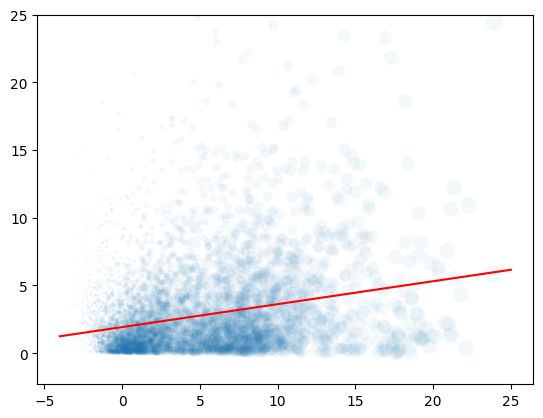

In [156]:
fig, ax = plt.subplots()
x, y = im.ravel(), _var.ravel()
pp = np.polynomial.Polynomial.fit(x, y, deg=1)
ax.scatter(x, y, marker="o", s=(4 + x)**1.5, alpha=0.05, linewidths=0)
xgrid = np.linspace(-4, 25)
ax.plot(xgrid, pp(xgrid), color="r")
ax.set_ylim(None, 25)

In [131]:
pp.convert()

Polynomial([1.9266678 , 0.16936185], domain=[-1.,  1.], window=[-1.,  1.])

So this is a similar intercept to before, but the slope is about half as big. This should be more reliable, since it includes a greater range of intensities. 

The variance itself has a larger variance at a given brightness level. It looks like there are curved periodic waves of high and low variance across the image, with typical wavelength of 10 to 20 pixels

In [132]:
from utils_chatgpt import regression_with_ci

(-2.2961599695320967, 15.0)

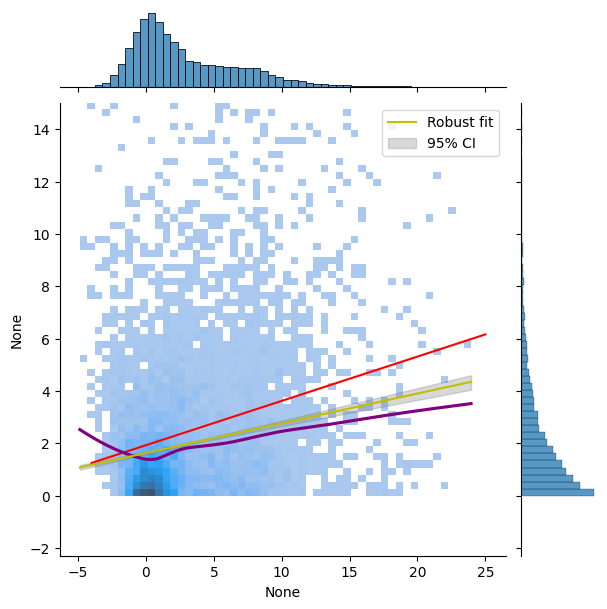

In [162]:
g = sns.jointplot(x=x, y=y, kind="hist", 
                  # joint_kws=dict(thresh=0.01),
                 )
g.ax_joint.plot(xgrid, pp(xgrid), color="r")
sns.regplot(x=x, y=y, lowess=True, scatter=False, color="purple", ax=g.ax_joint)
robust = regression_with_ci(
    x=x, y=y, robust=True, n_boot=100, 
    scatter=False, color="y", ax=g.ax_joint,
)
g.ax_joint.set_ylim(None, 15)
# sns.regplot(x=x, y=y, robust=True, scatter=False, color="y", ax=g.ax_joint)

This compares the non-parametic lowess interpolation (purple) with the linear fit (red). And it is plotted on top of the kde estimation of the joint distribution.

There is pretty good agreement between the two. Main differences are that 
1. Lowess is constant for negative brightness, which is natural because negative values are entirely due to noise. Obviouslpy, the linear fit cannot capture this detail.
2. Lowess values are about 10 to 20% lower at all brightness levels. Possibly it is a robust estimator, so is less affected by the high-variance tail

My suspiscion is correct. I also did a robust linear fit (yellow line) and that closely matches the lowess fit. 

In [134]:
robust["coefficients"][::-1]

array([1.6289742 , 0.11363001])

*Note that I had to reverse the coefficients to match the order from np.polynomial.Polynomial*

As suspected, both constant and linear term are about 10% lower than the standard fit:

In [135]:
pp.convert().coef

array([1.9266678 , 0.16936185])

Make a `Polynomial` instance of the robust fit.

In [136]:
ppp = np.polynomial.Polynomial(robust["coefficients"][::-1])
ppp

Polynomial([1.6289742 , 0.11363001], domain=[-1,  1], window=[-1,  1])

#### Subtract model from variance image

We can look at the residual variance after subtracting the linear model, which should be relatively flat. 

In [137]:
from astropy.convolution import convolve, Gaussian2DKernel

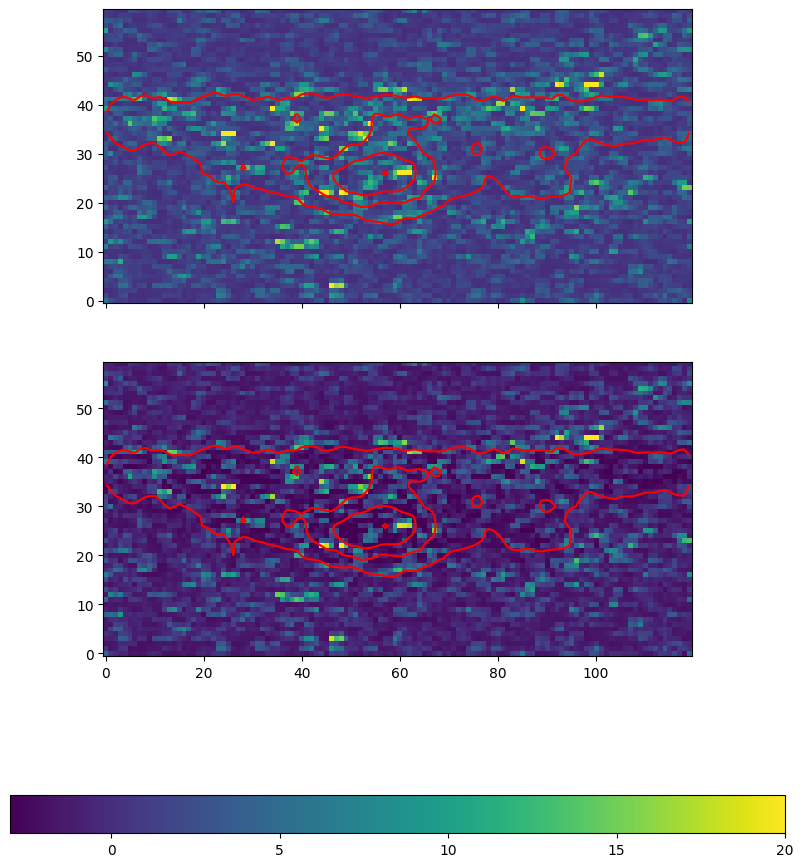

In [158]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 12))
ims = convolve(im, Gaussian2DKernel(1))
axes[0].imshow(_var, origin="lower", interpolation="none", vmin=-3, vmax=20)
_ = axes[1].imshow(_var - pp(im), origin="lower", interpolation="none", vmin=-3, vmax=20)
fig.colorbar(_, ax=axes, orientation="horizontal")
for ax in axes:
    ax.contour(ims, levels=[5, 10, 15, 20], colors="r")


#### Conclusion of noise model

The main thing I have learned is that:

***There is very litle variation of noise with brightness***

That is, that the noise systematically varies with position in the image, but this has very little to do with the image brightness. 
By looking at variance in the spatial direction only, I avoid the contribution from systematic brightness gradients and do manage to find a small dependence on the brightness. 

So main conclusion is:
$$
s^2 = 1.6 + 0.17 S
$$
where $s$ is rms noise and $S$ is brightness. 

So this gives $s = 1.3$ in faint parts, up to $s = 2.2$ in bright parts of the line. 

We can add $s^2$ linearly when combining several pixels, which will reduce the relative noise overall.


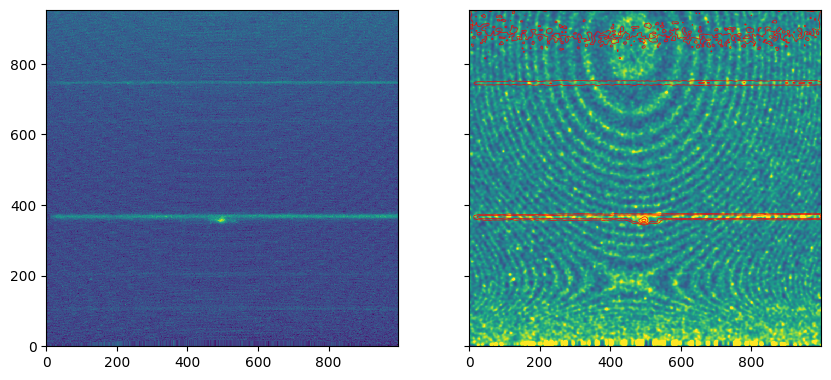

In [163]:
wav_window_full = slice(None, None)
pos_window_full = slice(None, None)
# convert to default float since fits image was big endian
im_full = hdu.data[wav_window_full, pos_window_full].astype("float")
bg_full = p(pixels)[wav_window_full, None]
im_full -= bg_full
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
axes[0].imshow(_med_full, origin="lower", interpolation="none")
_var_full, _med_full = x_variance(im_full)
axes[1].imshow(
    convolve(_var_full, Gaussian2DKernel(3)),
    origin="lower", interpolation="none", vmin=0, vmax=4)
axes[1].contour(
    convolve(im_full, Gaussian2DKernel(3)), 
    levels=[2.5, 5, 10, 15, 20], colors="r", linewidths=0.5)

In [140]:
w = WCS(hdu.header)
offsets, waves = w.pixel_to_world_values([0]*ny, np.arange(ny))

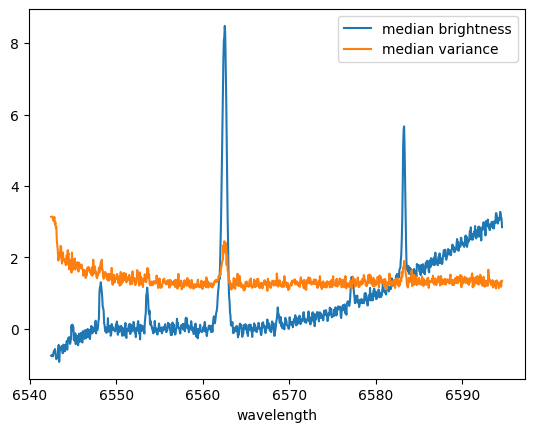

In [141]:
fig, ax = plt.subplots()
ax.plot(waves, np.median(im_full, axis=1), label="median brightness")
ax.plot(waves, np.median(_var_full, axis=1), label="median variance")
ax.set_xlabel("wavelength")
ax.legend()

In [142]:
from astropy import constants
import astropy.units as u

In [143]:
light_speed_kms = constants.c.to_value(u.km / u.s)
light_speed_kms

299792.458

In [144]:
wave0 = 6562.78

In [145]:
vels = light_speed_kms * (waves - wave0) / wave0

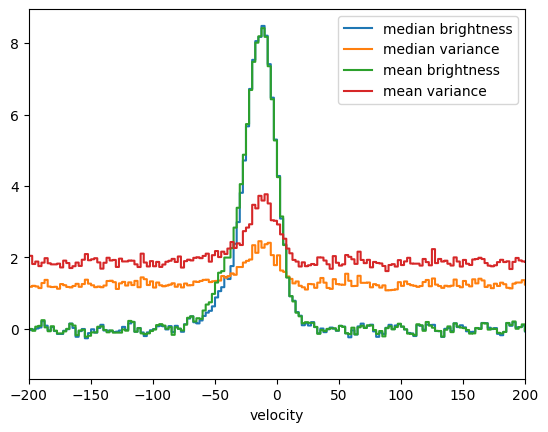

In [146]:
fig, ax = plt.subplots()
ax.plot(vels, np.median(im_full, axis=1), label="median brightness", ds="steps-mid")
ax.plot(vels, np.median(_var_full, axis=1), label="median variance", ds="steps-mid")
ax.plot(vels, np.mean(im_full, axis=1), label="mean brightness", ds="steps-mid")
ax.plot(vels, np.mean(_var_full, axis=1), label="mean variance", ds="steps-mid")
ax.set_xlabel("velocity")
ax.set_xlim(-200, 200)
ax.legend()

In [147]:
np.diff(vels)[0]

2.498936314386242

So it looks like we should just be using 1.7 for the variance, with no dependence on brightness. 

## Experiment with interpolating out high-variance pixels

In [152]:
factor = 2
mask = _var > factor * pp(im)
mask = _var > 9
mask.sum()

265

In [153]:
from astropy.convolution import interpolate_replace_nans, Gaussian2DKernel

In [154]:
im_nan = np.where(mask, np.nan, im)
kernel = Gaussian2DKernel(x_stddev=2, y_stddev=0.01)
im_repair = interpolate_replace_nans(im_nan, kernel)

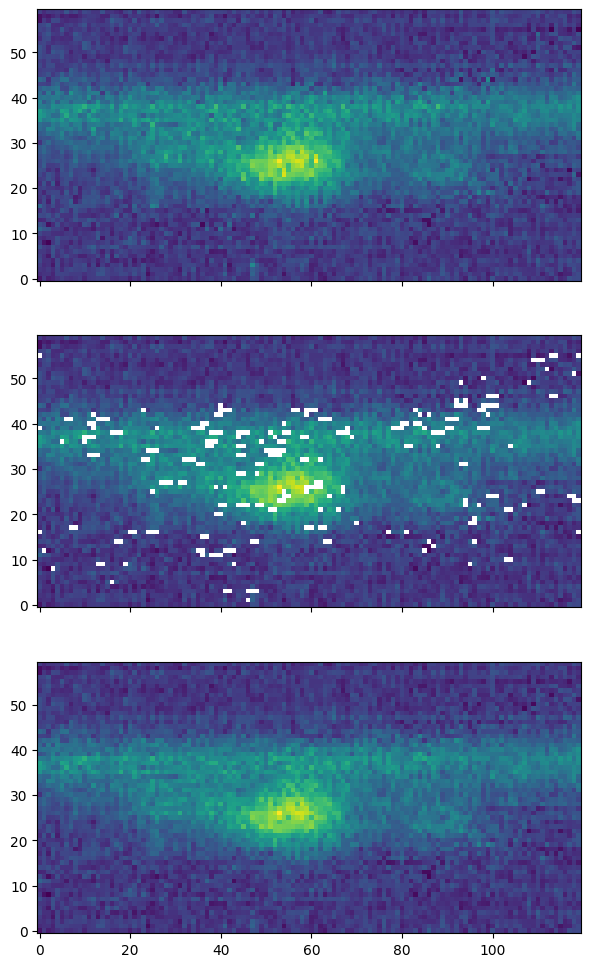

In [155]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 12))
axes[0].imshow(
    im, 
    origin="lower", interpolation="none")
axes[1].imshow(
    im_nan, 
    origin="lower", interpolation="none")
axes[2].imshow(
    im_repair, 
    origin="lower", interpolation="none")

In [24]:
Gaussian2DKernel?

Init signature: Gaussian2DKernel(x_stddev, y_stddev=None, theta=0.0, **kwargs)
Docstring:     
2D Gaussian filter kernel.

The Gaussian filter is a filter with great smoothing properties. It is
isotropic and does not produce artifacts.

The generated kernel is normalized so that it integrates to 1.

Parameters
----------
x_stddev : float
    Standard deviation of the Gaussian in x before rotating by theta.
y_stddev : float
    Standard deviation of the Gaussian in y before rotating by theta.
theta : float or `~astropy.units.Quantity` ['angle']
    Rotation angle. If passed as a float, it is assumed to be in radians.
    The rotation angle increases counterclockwise.
x_size : int, optional
    Size in x direction of the kernel array. Default = ⌊8*stddev + 1⌋.
y_size : int, optional
    Size in y direction of the kernel array. Default = ⌊8*stddev + 1⌋.
mode : {'center', 'linear_interp', 'oversample', 'integrate'}, optional
    One of the following discretization modes:
        * 'center'